## Imports

In [1]:
import os
import csv
import konlpy
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
%matplotlib inline

In [2]:
mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


## Data load

In [3]:
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


## EDA

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


/tmp/ipykernel_31/2284205290.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


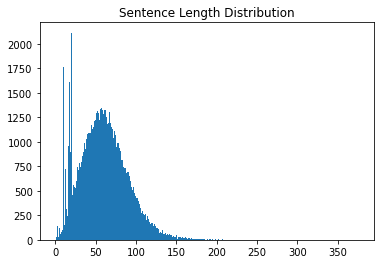

In [4]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [5]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

’


In [6]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


In [76]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


/tmp/ipykernel_31/390535405.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


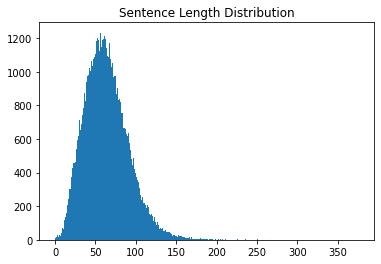

In [8]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

/tmp/ipykernel_31/1483434014.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max_len), dtype=np.int)


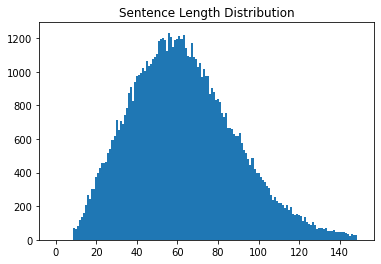

In [9]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## Space-based tokenizer

In [10]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)
    '''
    위의 tokenizer 코드
    : corpus를 쪼개서 단어사전을 만듬
    '''

    tensor = tokenizer.texts_to_sequences(corpus)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    '''
    위의 tensor 코드
    : corpus에 담긴 각 문장들을 단어사전으로 표현함
    '''
    return tensor, tokenizer

# tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
# tokenizer.fit_on_texts(split_corpus[:1])
# tokenizer.word_index
# tokenizer.index_word
# tensor = tokenizer.texts_to_sequences(split_corpus[:1])
# tensor
# tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
# tensor


In [11]:
# 정제된 데이터를 공백 기반으로 토큰화하여 저장하는 코드를 직접 작성해 보세요.
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [12]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))
'''
index_word 메소드
: index to word
'''

Split Vocab Size: 237435


In [13]:
for idx, word in enumerate(split_tokenizer.word_index):
    '''
    word_index 메소드
    : word to index
    '''
    
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


## Morpheme-based tokenizer

In [34]:
# 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [35]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52279


In [37]:
texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

아놀드 슈워제네거 캘리포니아 주지사 는 화재 피해 가 43 만 4543 에 어 커 로 증가 했 다고 밝혔 다 .


In [38]:
sentence = ""
for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + ""
print(sentence)

아놀드슈워제네거캘리포니아주지사는화재피해가43만4543에어커로증가했다고밝혔다.


## SentencePieceModel tokenizer

In [28]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 100000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

NameError: name 'filtered_corpus' is not defined

In [41]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [42]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [43]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1956 5665    5    4 7975 1990    3    0    0    0    0    0    0    0]
 [ 107 1641  101    4    0  417   11    4   14    0 1976    3    3    3]]


## Application of SentencePiece to the sentiment analysis of Naver moive review

## Data load

In [4]:
data = pd.read_table(os.getenv('HOME') + '/aiffel/sp_tokenizer/data/nsmc/ratings.txt')

data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


## Preprocessing

In [5]:
print(f'Data의 크기 : {len(data)}')

Data의 크기 : 200000


In [6]:
data[data.document.str.contains('nan', na = False)]

,id,document,label
125229,143967,이미 참여하셨습니다.qenansfyd123,0


In [7]:
data[data.duplicated(['document'])]

,id,document,label
187,3946738,굿,1
740,4217807,재밌다,1
1369,3044092,재밋다,1
1535,6924850,굿,1
1896,2417941,쵝오,1
...,...,...,...
199932,2334732,지루함...,0
199939,2105796,bad,0
199944,2100743,재미없다...,0
199946,735755,에혀,0


In [8]:
print(f'Id 컬럼의 Na 갯수 : { len(data[data.id.isnull()]) }')
print(f'Document 컬럼의 Na 갯수 : {len(data[data.document.isnull()])}')
print(f'Label 컬럼의 Na 갯수 : {len(data[data.label.isnull()])}')

data[data['document'].isnull()]

Id 컬럼의 Na 갯수 : 0
Document 컬럼의 Na 갯수 : 8
Label 컬럼의 Na 갯수 : 0


,id,document,label
46471,6369843,NaN,1
60735,511097,NaN,1
77665,2172111,NaN,1
84098,402110,NaN,1
127017,5942978,NaN,0
172375,5026896,NaN,0
173526,1034280,NaN,0
197279,1034283,NaN,0


In [9]:
data.dropna(how = 'any', inplace = True)
data.drop_duplicates('document', inplace = True)

In [10]:
data = data[~data.document.str.contains('nan')]

In [11]:
print(f'Preprocessed data의 크기 : {len(data)}')

Preprocessed data의 크기 : 194542


#### Training

In [12]:
naver_review = data['document']

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


/tmp/ipykernel_32/2328176167.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_length = np.zeros((max_len), dtype=np.int)


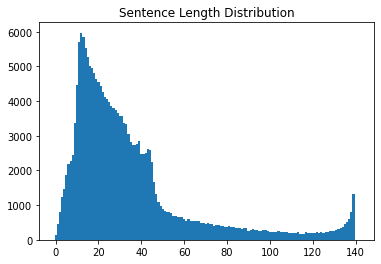

In [13]:
min_len = 999
max_len = 0
sum_len = 0

for sen in naver_review:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(naver_review))

train_length = np.zeros((max_len), dtype=np.int)

for sen in naver_review:   # 중복이 제거된 코퍼스 기준
    train_length[len(sen)-1] += 1

plt.bar(range(max_len), train_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [14]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(naver_review, 141)

/tmp/ipykernel_32/148705089.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_length = np.zeros((max_len), dtype=np.int)


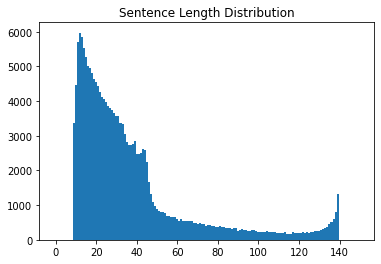

In [15]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
#review_filtered = [s for s in data if (len(s) < max_len) & (len(s) >= min_len)]
filtered_data = data[(data['document'].str.len() < max_len) & (data['document'].str.len() >= min_len)]

# 분포도를 다시 그려봅니다.
train_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_data['document']:
    train_length[len(sen)-1] += 1

plt.bar(range(max_len), train_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [16]:
print(f'Filtered data의 크기 : {len(filtered_data)}')

Filtered data의 크기 : 181695


## SentencePieceModel tokenizer

#### Training

In [20]:
temp_file = os.getenv('HOME') + '/aiffel/sp_tokenizer/data/nsmc/ratings.txt.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_data['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_unigram_8k --vocab_size={}'.format(temp_file, vocab_size)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bep_8k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/nsmc/ratings.txt.temp --model_prefix=kor_spm_unigram_8k --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/nsmc/ratings.txt.temp
  input_format: 
  model_prefix: kor_spm_unigram_8k
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bo

In [21]:
!ls -l kor_spm_unigram_8k*
!ls -l kor_spm_bep_8k*

-rw-r--r-- 1 root root 374860 Jul  8 02:23 kor_spm_unigram_8k.model
-rw-r--r-- 1 root root 144321 Jul  8 02:23 kor_spm_unigram_8k.vocab
-rw-r--r-- 1 root root 370341 Jul  8 02:23 kor_spm_bep_8k.model
-rw-r--r-- 1 root root 115555 Jul  8 02:23 kor_spm_bep_8k.vocab


In [22]:
vocab_list = pd.read_csv('kor_spm_bep_8k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_list[:10]

,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,▁아,-4
8,...,-5
9,▁그,-6


In [23]:
vocab_list.sample(10)

,0,1
6413,유,-6410
2781,무비,-2778
6185,년대에,-6182
7680,욧,-7677
5025,▁부모님,-5022
6554,크,-6551
231,▁죽,-228
3632,대를,-3629
7968,츰,-7965
4931,▁아깝고,-4928


In [24]:
def test_performance(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [25]:
print('kor_spm_unigram_8k')
test_performance(model='kor_spm_unigram_8k.model')

print('kor_spm_bep_8k')
test_performance(model='kor_spm_bep_8k.model')

kor_spm_unigram_8k
[1390, 10, 382, 15, 1303, 10, 129, 18, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.
kor_spm_bep_8k
[4803, 869, 6549, 6298, 6317, 1370, 6395, 6288, 6286]
['▁아버', '지가', '방', '에', '들', '어가', '신', '다', '.']
아버지가방에들어가신다.


In [26]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./kor_spm_bep_8k.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [27]:
s = spm.SentencePieceProcessor()
s.Load('kor_spm_bep_8k.model')

tensor, word_index, index_word = sp_tokenize(s, filtered_data['document'])
print(tensor)

[[1744  161  227 ...    0    0    0]
 [ 740 6342 2188 ...    0    0    0]
 [3131  685  636 ...    0    0    0]
 ...
 [ 216 5321    4 ...    0    0    0]
 [  84 6433  157 ...    0    0    0]
 [ 339 6851 6424 ...    0    0    0]]


## LSTM

In [28]:
vocab_size = 8000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 128  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [29]:
from sklearn.model_selection import train_test_split

filtered_label = np.array(filtered_data['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128, return_sequences = True))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1024000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
dense (Dense)                (None, None, 1)           129       
Total params: 1,155,713
Trainable params: 1,155,713
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [32]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [33]:
epochs=20
batch_size=64

lstm_history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=[early,check],
                    verbose=1)

Epoch 1/20
1817/1817 [==============================] - 872s 479ms/step - loss: 0.5641 - accuracy: 0.7136 - val_loss: 0.5171 - val_accuracy: 0.7789

Epoch 00001: saving model to best_model_lstm.h5
Epoch 2/20
1817/1817 [==============================] - 875s 481ms/step - loss: 0.4747 - accuracy: 0.7921 - val_loss: 0.5227 - val_accuracy: 0.7719

Epoch 00002: saving model to best_model_lstm.h5
Epoch 3/20
1817/1817 [==============================] - 870s 479ms/step - loss: 0.4649 - accuracy: 0.7850 - val_loss: 0.4298 - val_accuracy: 0.8028

Epoch 00003: saving model to best_model_lstm.h5
Epoch 4/20
1817/1817 [==============================] - 868s 478ms/step - loss: 0.3605 - accuracy: 0.8441 - val_loss: 0.3732 - val_accuracy: 0.8320

Epoch 00004: saving model to best_model_lstm.h5
Epoch 5/20
1817/1817 [==============================] - 870s 479ms/step - loss: 0.3079 - accuracy: 0.8661 - val_loss: 0.3421 - val_accuracy: 0.8471

Epoch 00005: saving model to best_model_lstm.h5
Epoch 6/20
1817

In [34]:
def visualize_train(train_history, param):
    # summarize history for accuracy
    plt.plot(train_history.history['accuracy'])
    plt.plot(train_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(train_history.history['loss'])
    plt.plot(train_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

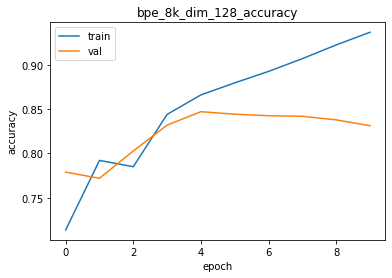

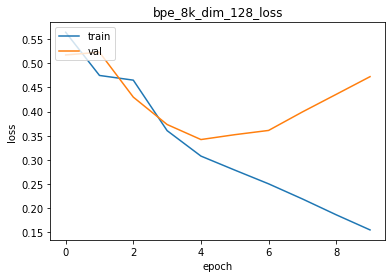

In [35]:
visualize_train(lstm_history, param = 'bpe_8k_dim_128')

## Discussion

1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?  
 - 코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?  
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?  
 - SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.  
3. SentencePiece의 성능을 다각도로 비교분석하였는가?  
 - SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

## Reference

1. https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-02%5DSentencePiece.ipynb